In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_name = os.getenv("DB_NAME")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")

In [4]:
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(db_url)

In [5]:
query = "SELECT * FROM intel;"
df = pd.read_sql(query, engine)

In [6]:
print(df.columns)

Index(['produktsortiment', 'prozessornummer', 'litographie_nm',
       'anzahl_der_kerne', 'gesamte_threads', 'max_turbo_taktfrequenz_GHz',
       'intel_turbo_boost_technik_2_0_taktfrequenz_GHz',
       'grundtaktfrequenz_des_prozessors_GHz', 'cache_MB',
       'bus_taktfrequenz_GT_per_s', 'verlustleistung_tdp_W',
       'x_of_performance_cores', 'x_of_efficiency_cores',
       'intel_turbo_boost_max_technology_3_0_frequency_GHz',
       'single_p_core_turbo_frequency_GHz',
       'single_e_core_turbo_frequency_GHz', 'p_core_base_frequency',
       'e_core_base_frequency_GHz', 'total_l2_cache_MB',
       'processor_base_power_W', 'maximum_turbo_power_W', 'einfuhrungsdatum',
       'expected_discontinuance', 'grundtaktfrequenz_der_grafik_MHz',
       'max_dynamische_grafikfrequenz_GHz', 'max_videospeicher_der_grafik_GB',
       'x4k_unterstutzung_at', 'max_auflosung_hdmi', 'max_auflosung_dp',
       'max_auflosung_e_dp_integrierter_flachbildschirm',
       'pci_express_konfigurationen'

In [7]:
def convert_quarter_to_date(quarter_str):
    quarter, year = quarter_str.split("'")
    year = int("20" + year)
    month = {"Q1": 1, "Q2": 4, "Q3": 7, "Q4": 10}[quarter]
    return pd.Timestamp(year=year, month=month, day=1)

df['einfuhrungsdatum'] = df['einfuhrungsdatum'].apply(convert_quarter_to_date)
df['jahr'] = df['einfuhrungsdatum'].dt.year

In [8]:
number_words = {
    "erste": 1, "zweite": 2, "dritte": 3, "vierte": 4, "fünfte": 5,
    "sechste": 6, "siebte": 7, "achte": 8, "neunte": 9, "zehnte": 10
}

def extract_generation(gen_text):
    match_numeric = re.search(r'(\d+)(?:\.|th)?\s?Gen', gen_text, re.IGNORECASE)
    if match_numeric:
        return int(match_numeric.group(1))
    for word, num in number_words.items():
        if word in gen_text.lower():
            return num
    return None

df['generation'] = df['produktsortiment'].apply(extract_generation)

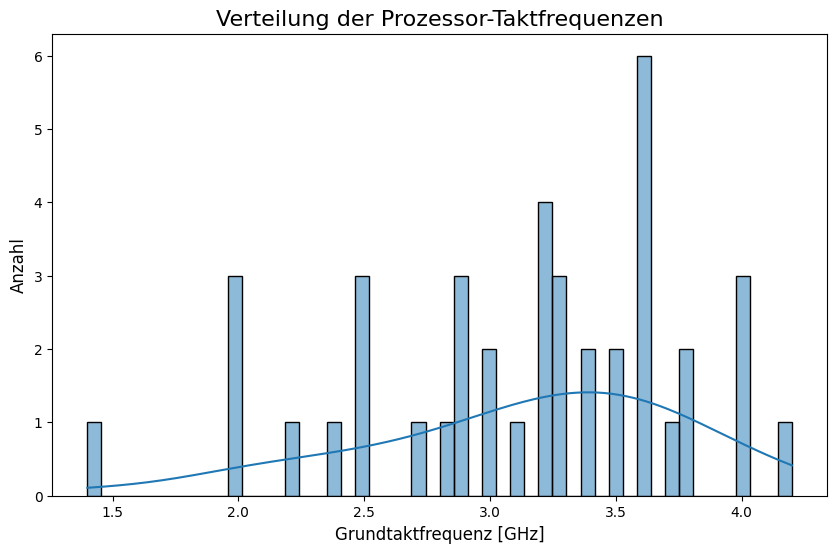

In [9]:
plt.figure(figsize=(10,6))
sn.histplot (df['grundtaktfrequenz_des_prozessors_GHz'], bins=50, kde=True)
plt.title("Verteilung der Prozessor-Taktfrequenzen", fontsize=16)
plt.xlabel("Grundtaktfrequenz [GHz]", fontsize=12)
plt.ylabel("Anzahl", fontsize=12)
plt.show()

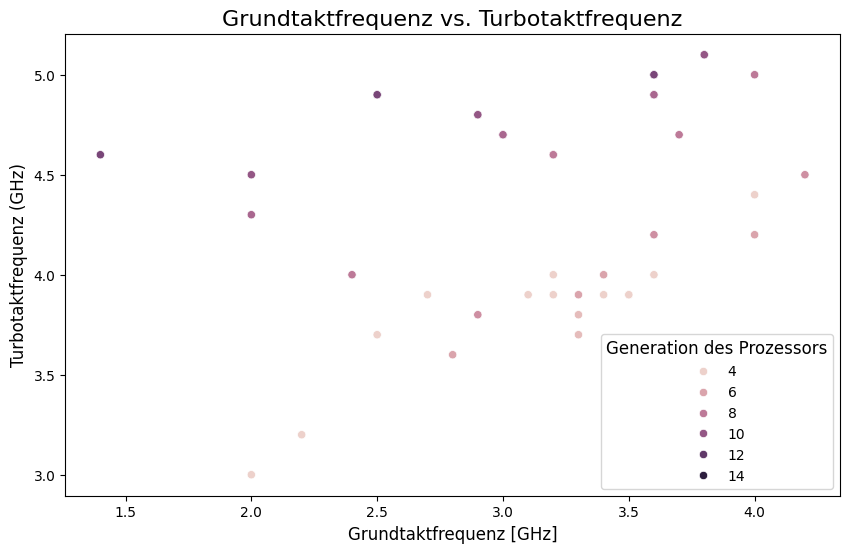

In [10]:
plt.figure(figsize=(10, 6))
sn.scatterplot(data=df, x='grundtaktfrequenz_des_prozessors_GHz', y='max_turbo_taktfrequenz_GHz', hue='generation')
plt.title("Grundtaktfrequenz vs. Turbotaktfrequenz", fontsize=16)
plt.legend(title='Generation des Prozessors', fontsize=10, title_fontsize=12)
plt.xlabel("Grundtaktfrequenz [GHz]", fontsize=12)
plt.ylabel("Turbotaktfrequenz (GHz)", fontsize=12)
plt.show()

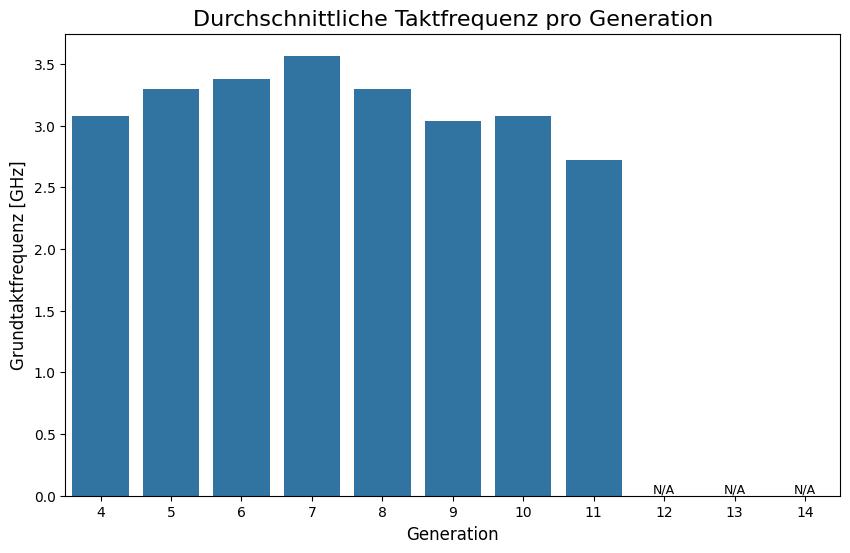

In [11]:
avg_clock_per_gen = df.groupby('generation')['grundtaktfrequenz_des_prozessors_GHz'].mean().reset_index()

plt.figure(figsize=(10, 6))
sn.barplot(data=avg_clock_per_gen, x='generation', y='grundtaktfrequenz_des_prozessors_GHz')
plt.title("Durchschnittliche Taktfrequenz pro Generation", fontsize=16)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Grundtaktfrequenz [GHz]", fontsize=12)

for i, row in avg_clock_per_gen.iterrows():
    if np.isnan(row['grundtaktfrequenz_des_prozessors_GHz']):
        plt.text(i, 0, 'N/A', ha='center', va='bottom', fontsize=9)

plt.show()

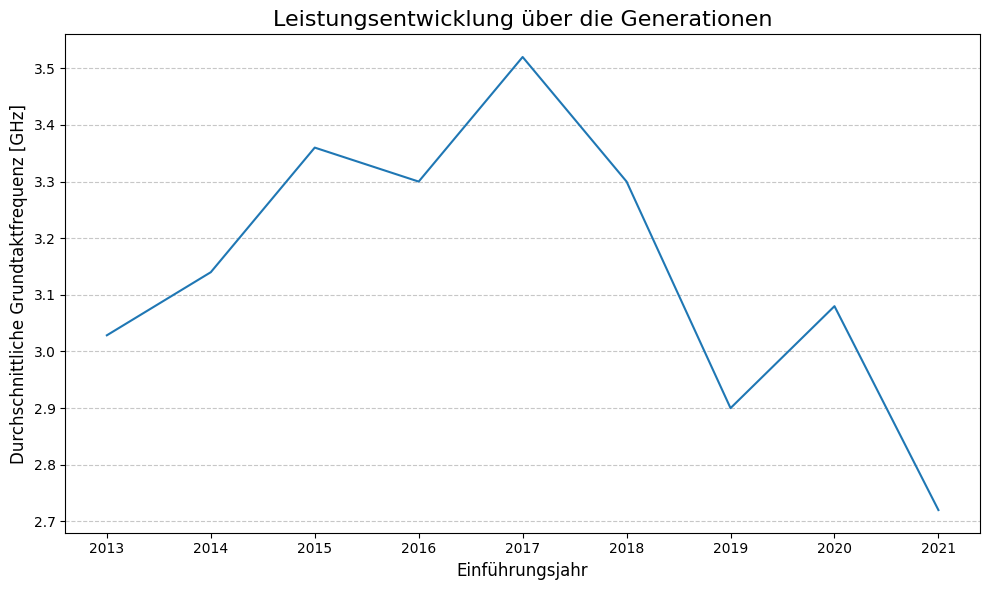

In [12]:
performance_by_year = df.groupby('jahr')['grundtaktfrequenz_des_prozessors_GHz'].mean().reset_index()

plt.figure(figsize=(10, 6))
sn.lineplot(data=performance_by_year, x='jahr', y='grundtaktfrequenz_des_prozessors_GHz')
plt.title("Leistungsentwicklung über die Generationen", fontsize=16)
plt.xlabel("Einführungsjahr", fontsize=12)
plt.ylabel("Durchschnittliche Grundtaktfrequenz [GHz]", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

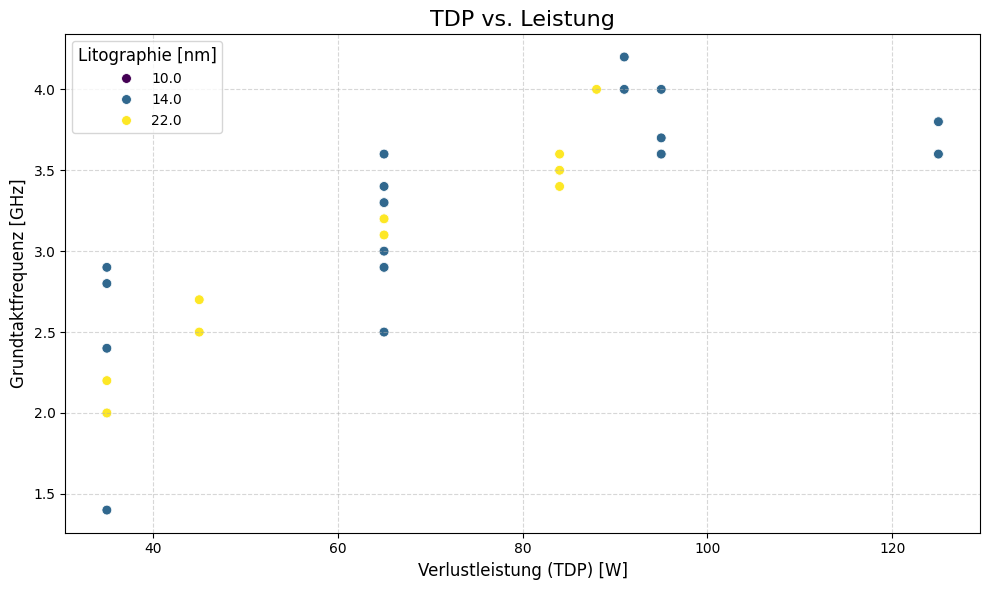

In [13]:
plt.figure(figsize=(10, 6))
sn.scatterplot(data=df, x='verlustleistung_tdp_W', y='grundtaktfrequenz_des_prozessors_GHz', hue='litographie_nm', palette='viridis', s=50)

plt.title('TDP vs. Leistung', fontsize=16)
plt.xlabel('Verlustleistung (TDP) [W]', fontsize=12)
plt.ylabel('Grundtaktfrequenz [GHz]', fontsize=12)
plt.legend(title='Litographie [nm]', fontsize=10, title_fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

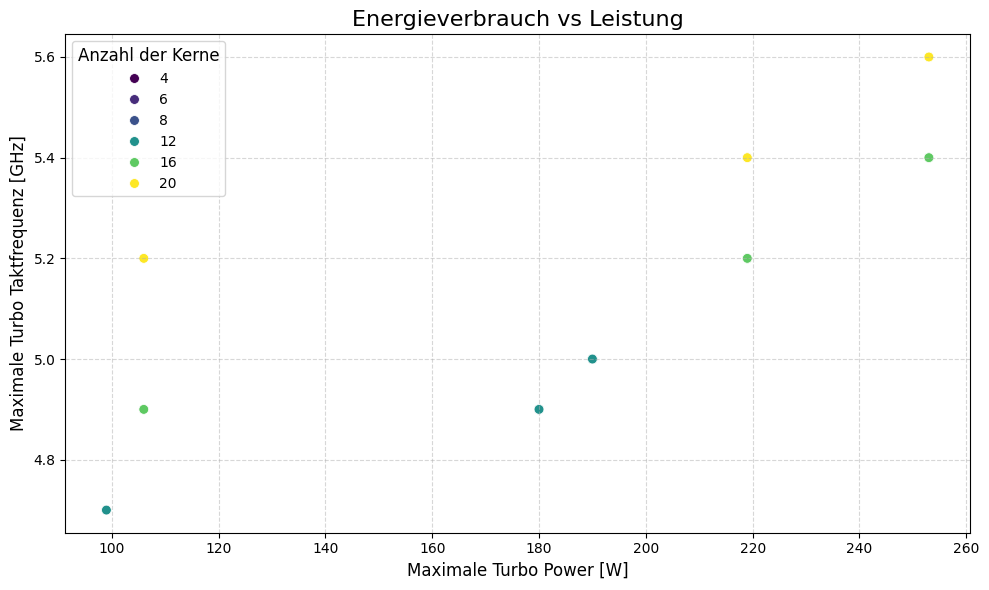

In [14]:
plt.figure(figsize=(10, 6))
sn.scatterplot(data=df, x='maximum_turbo_power_W', y='max_turbo_taktfrequenz_GHz', hue='anzahl_der_kerne', palette='viridis', s=50)

plt.title('Energieverbrauch vs Leistung', fontsize=16)
plt.xlabel('Maximale Turbo Power [W]', fontsize=12)
plt.ylabel('Maximale Turbo Taktfrequenz [GHz]', fontsize=12)
plt.legend(title='Anzahl der Kerne', fontsize=10, title_fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

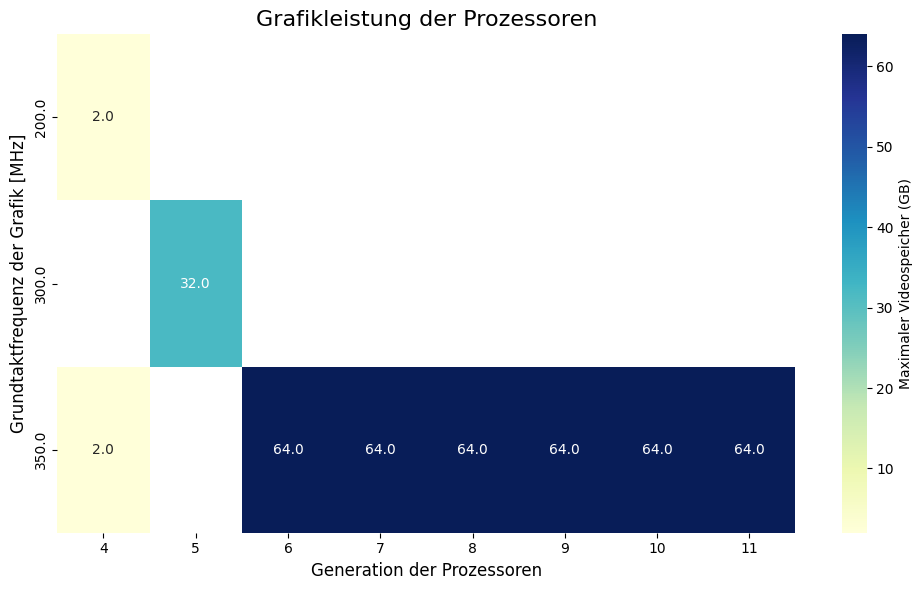

In [15]:
heatmap_data=df.pivot_table(index='grundtaktfrequenz_der_grafik_MHz',columns='generation',values='max_videospeicher_der_grafik_GB')

plt.figure(figsize=(10, 6))
sn.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Maximaler Videospeicher (GB)'})
plt.title("Grafikleistung der Prozessoren", fontsize=16)
plt.xlabel("Generation der Prozessoren", fontsize=12)
plt.ylabel("Grundtaktfrequenz der Grafik [MHz]", fontsize=12)
plt.tight_layout()
plt.show()

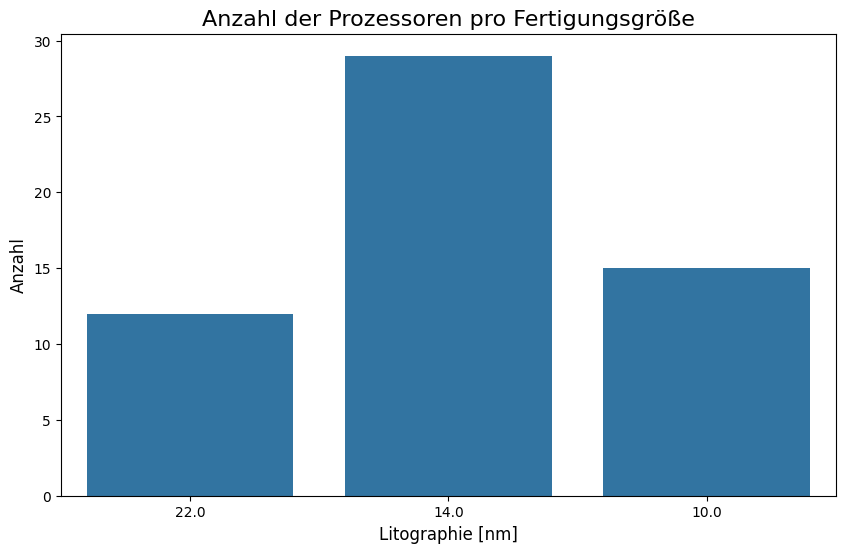

In [16]:
plt.figure(figsize=(10, 6))
sn.countplot(data=df, x='litographie_nm', order=sorted(df['litographie_nm'], reverse=True))
plt.title("Anzahl der Prozessoren pro Fertigungsgröße", fontsize=16)
plt.xlabel("Litographie [nm]", fontsize=12)
plt.ylabel("Anzahl", fontsize=12)
plt.show()

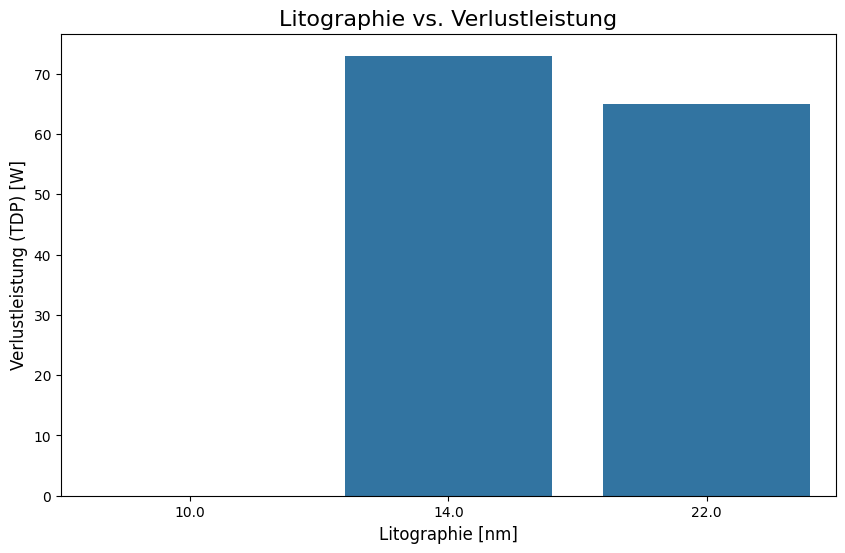

In [17]:
plt.figure(figsize=(10, 6))
sn.barplot(data=df, x='litographie_nm', y='verlustleistung_tdp_W', errorbar=None)
plt.title("Litographie vs. Verlustleistung", fontsize=16)
plt.xlabel("Litographie [nm]", fontsize=12)
plt.ylabel("Verlustleistung (TDP) [W]", fontsize=12)
plt.show()

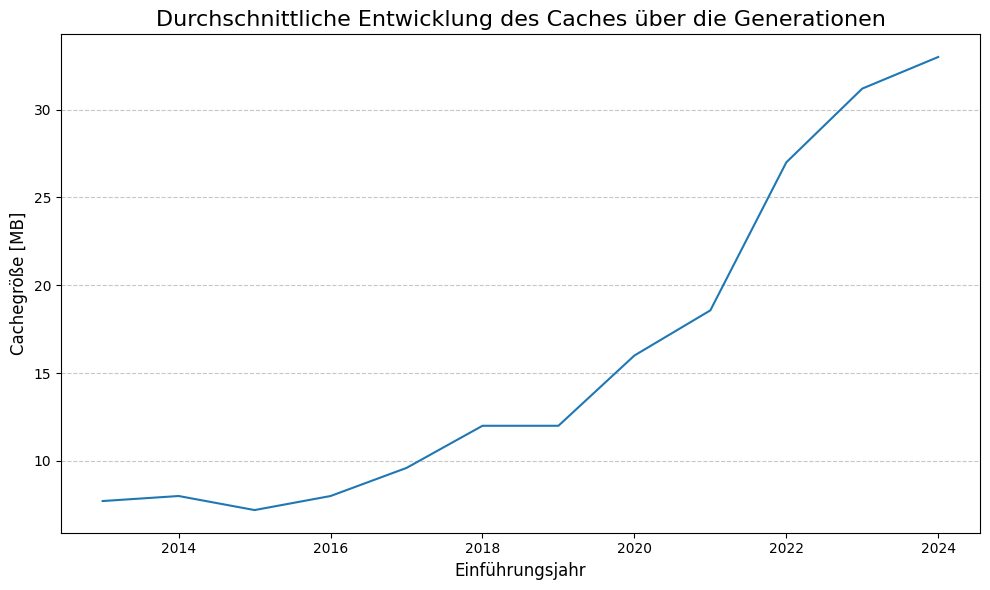

In [29]:
cache_by_year = df.groupby('jahr')['cache_MB'].mean().reset_index()

plt.figure(figsize=(10, 6))
sn.lineplot(data=cache_by_year, x='jahr', y='cache_MB')
plt.title("Durchschnittliche Entwicklung des Caches über die Generationen", fontsize=16)
plt.xlabel("Einführungsjahr", fontsize=12)
plt.ylabel("Cachegröße [MB]", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

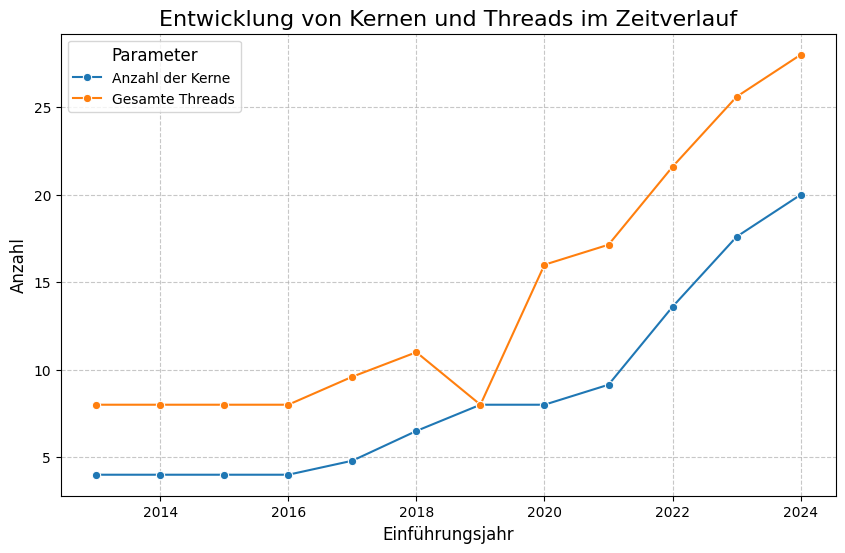

In [19]:
plt.figure(figsize=(10, 6))
sn.lineplot(data=df, x='jahr', y='anzahl_der_kerne', label='Anzahl der Kerne', marker='o', errorbar=None)
sn.lineplot(data=df, x='jahr', y='gesamte_threads', label='Gesamte Threads', marker='o', errorbar=None)

plt.title('Entwicklung von Kernen und Threads im Zeitverlauf', fontsize=16)
plt.xlabel('Einführungsjahr', fontsize=12)
plt.ylabel('Anzahl', fontsize=12)
plt.legend(title='Parameter', fontsize=10, title_fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)

plt.show()

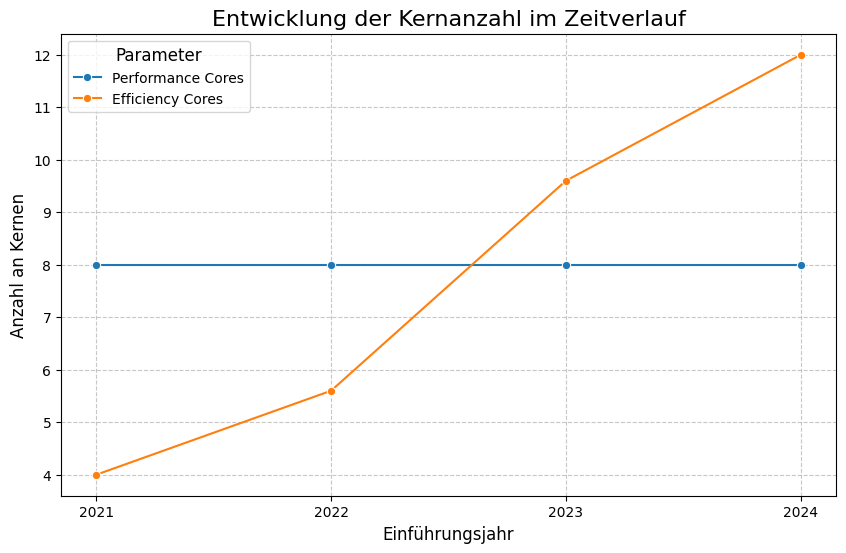

In [20]:
valid_years = df.dropna(subset=['x_of_performance_cores', 'x_of_efficiency_cores'])['jahr'].unique()

plt.figure(figsize=(10, 6))
sn.lineplot(data=df, x='jahr', y='x_of_performance_cores', label='Performance Cores', marker='o', errorbar=None)
sn.lineplot(data=df, x='jahr', y='x_of_efficiency_cores', label='Efficiency Cores', marker='o', errorbar=None)

plt.title('Entwicklung der Kernanzahl im Zeitverlauf', fontsize=16)
plt.xlabel('Einführungsjahr', fontsize=12)
plt.ylabel('Anzahl an Kernen', fontsize=12)
plt.legend(title='Parameter', fontsize=10, title_fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.xticks(ticks=valid_years)
plt.show()

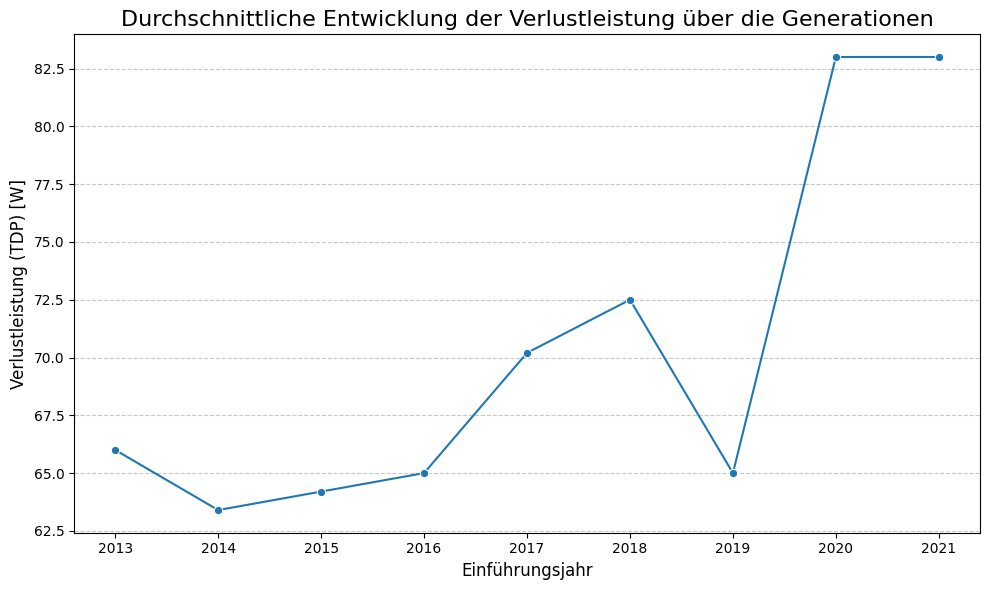

In [28]:
plt.figure(figsize=(10, 6))
sn.lineplot(data=df, x='jahr', y='verlustleistung_tdp_W', marker='o', errorbar=None)
plt.title("Durchschnittliche Entwicklung der Verlustleistung über die Generationen", fontsize=16)
plt.xlabel("Einführungsjahr", fontsize=12)
plt.ylabel("Verlustleistung (TDP) [W]", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()